In [1]:
from FileUtils import FileUtils
import matplotlib.pyplot as plt 
import os
import torch
from Settings import Settings
from ReplayMemory import Transition, ReplayMemory

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
data = FileUtils(100)
data.filter_by_class("cat")

Start to load data
Start to load images: 100!
Start to load annotations: 100!
End


In [3]:
from Image import Image

(375, 500, 3)


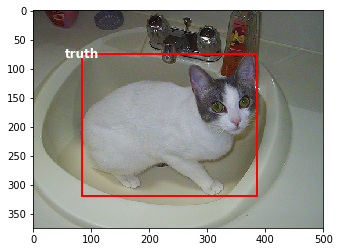

(375, 500, 3)


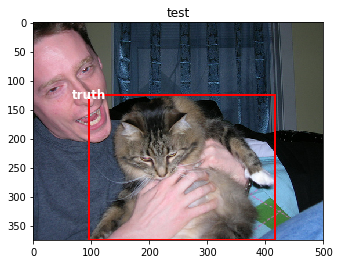

In [6]:
img = Image(data, 4)
print(img.image.shape)
img.add_text("truth", (img.objects[0]["xmin"],img.objects[0]["ymin"]))
img.draw_one_box(img.objects[0])
img.show()

img = Image(data, 3)
print(img.image.shape)
img.add_text("truth", (img.objects[0]["xmin"],img.objects[0]["ymin"]))
img.draw_one_box(img.objects[0])
img.save_fig("test")
img.show()

In [7]:
from Agent import Agent

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/xi.chenyu/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:08<00:00, 65.2MB/s] 


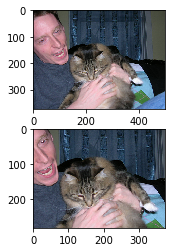

In [8]:
agent = Agent(img.image)
agent.hierarchical_move(5)
agent.update_history_vector(5)
plt.subplot(2, 1, 1)
plt.imshow(agent.image)
plt.subplot(2, 1, 2)
plt.imshow(agent.sub_image)

In [9]:
memo = ReplayMemory(10)

In [10]:
from Models import QModel

In [13]:
q_model = QModel()
q_model = q_model.cuda()

In [14]:
for i in range(20):
    memo.push(agent.get_state(), agent.get_next_action(q_model, 0.5), agent.get_state(), 1)
    memo.push(agent.get_state(), agent.get_next_action(q_model, 0.5), None, 3)

In [15]:
transitions = memo.sample(5)

In [16]:
batch = Transition(*zip(*transitions))

In [17]:
print(batch)

Transition(state=(tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<CatBackward>), tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<CatBackward>), tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<CatBackward>), tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<CatBackward>), tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<CatBackward>)), action=(tensor(2, device='cuda:0'), tensor(1, device='cuda:0'), tensor(4, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0')), next_state=(tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<CatBackward>), tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<CatBackward>), None, tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<CatBackward>), None), reward=(1, 1, 3, 1, 3))


In [18]:
def use_cuda(tensor, cuda=Settings.cuda):
    if cuda:
        tensor = tensor.cuda()
    return tensor


In [19]:
non_finals = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
non_finals = use_cuda(non_finals)
non_finals

tensor([ True,  True, False,  True, False], device='cuda:0')

In [20]:
with torch.no_grad():
    next_states = [s for s in batch.next_state if s is not None]
    non_final_next_states = torch.cat(next_states).type(torch.float)
    non_final_next_states = use_cuda(non_final_next_states)

non_final_next_states.shape

torch.Size([3, 25112])

In [21]:
state_batch = torch.cat(batch.state).type(torch.float)
state_batch = use_cuda(state_batch)
state_batch.shape

torch.Size([5, 25112])

In [22]:
from torch.autograd import Variable

In [34]:
action_batch = torch.tensor(batch.action, dtype=torch.long).view(-1, 1)
action_batch = use_cuda(action_batch)

In [35]:
action_batch

tensor([[2],
        [1],
        [4],
        [5],
        [5]], device='cuda:0')

In [36]:
reward_batch = torch.tensor(batch.reward, dtype=torch.float).view(-1, 1)
reward_batch = use_cuda(reward_batch)

In [37]:
reward_batch

tensor([[1.],
        [1.],
        [3.],
        [1.],
        [3.]], device='cuda:0')

In [39]:
state_action_values = q_model(state_batch).gather(1, action_batch - 1) 

In [40]:
state_action_values

tensor([[ 0.0664],
        [-0.2777],
        [-0.4848],
        [ 0.3929],
        [ 0.5269]], device='cuda:0', grad_fn=<GatherBackward>)

In [41]:
state_action_values.shape

torch.Size([5, 1])

In [42]:
action_batch

tensor([[2],
        [1],
        [4],
        [5],
        [5]], device='cuda:0')

In [44]:
next_state_values = torch.zeros(5)
next_state_values = use_cuda(next_state_values)

next_state_values[non_finals] = q_model(non_final_next_states).max(1)[0].detach()
next_state_values.view(-1, 1)

tensor([[0.2821],
        [0.2619],
        [0.0000],
        [0.7513],
        [0.0000]], device='cuda:0')

In [45]:
next_state_values = next_state_values.view(-1, 1)

In [46]:
expected_state_action_values = (next_state_values * Settings.gamma) + reward_batch


In [47]:
expected_state_action_values

tensor([[1.2818],
        [1.2616],
        [3.0000],
        [1.7506],
        [3.0000]], device='cuda:0')

In [48]:
state_action_values.shape

torch.Size([5, 1])

In [49]:
import torch.nn.functional as F

In [50]:
loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)

In [51]:
loss

tensor(1.5140, device='cuda:0', grad_fn=<SmoothL1LossBackward>)